<h1 align = "center"> MSU-NIST </h1>

## CS:3210 Machine Learning Final Project
### Professor: Feng Jiang 


#### Team Members:
* **Ling Thang**
* **Joaquin Trujillo**

#### Project Description:
For our Final project we have decided to work on the classic digit recognition problem. Taking a spin on the classic MNSIT dataset we have decided to collect our own dataset from around the Auraria campus housing the three schools MSU Denver, CU Denver, and CCD. We decided to take this approach because we believe that as machine learning students it is not only important to understand not just the application of machine learning but also the data collection, preprocessing, and cleaning that are the core of Machine Learning. We believe that this will give us a better understanding of the process and the challenges that come with it as well as the importance of data quality.

## Data Preprocessing:
* Data preprocessing refers to the transformations applied to our data before feeding it to the algorithm.

<img src="./Data/SampleData.png" width="200" height="300" alt="Sample Image" style="margin-left: 300px; margin-right: auto;">

* each of the digits are then converted to their own individual images and saved in their respective folders.

<div style="margin-left: 40px;">
    <img src="./Data/0/A_1.png" width="100" height="100" alt="Sample0" style="margin-bottom: 10px;">
    <img src="./Data/1/B_19.png" width="100" height="100" alt="Sample1" style="margin-bottom: 10px;">
    <img src="./Data/2/C_87.png" width="100" height="100" alt="Sample2" style="margin-bottom: 10px;">
    <img src="./Data/3/D_23.png" width="100" height="100" alt="Sample3" style="margin-bottom: 10px;">
    <img src="./Data/4/E_65.png" width="100" height="100" alt="Sample4" style="margin-bottom: 10px;">
    <img src="./Data/5/F_27.png" width="100" height="100" alt="Sample5" style="margin-bottom: 10px;">
    <img src="./Data/6/G_89.png" width="100" height="100" alt="Sample6" style="margin-bottom: 10px;">
    <img src="./Data/7/H_42.png" width="100" height="100" alt="Sample7" style="margin-bottom: 10px;">
    <img src="./Data/8/I_33.png" width="100" height="100" alt="Sample8" style="margin-bottom: 10px;">
    <img src="./Data/9/J_94.png" width="100" height="100" alt="Sample9" style="margin-bottom: 10px;">
</div>








## Imports and libraries used in the project


In [24]:
# Standard library imports
import os
from PIL import Image

# Third-party library imports
import numpy as np
import cv2
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# Data Injestion 

#### Data injestion is the process of obtaining and importing data for immediate use or storage in a database

our method of data injestion involved automating the process of resizing and normalizing the images to a standard size of 28x28 pixels. Then coverting the arrary to a numpy array and saving it to a npy file for easy access and manipulation.


Classes and the number of images in each:
class 0: 100 images
class 1: 100 images
class 2: 100 images
class 3: 100 images
class 4: 100 images
class 5: 100 images
class 6: 100 images
class 7: 100 images
class 8: 100 images
class 9: 100 images


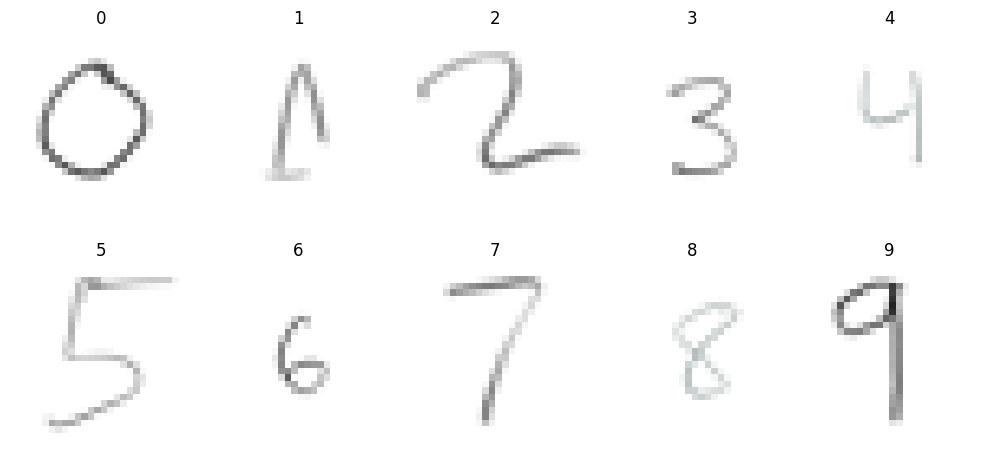

In [25]:
data_dir = 'Data'
# classes but only the directories
files = os.listdir(data_dir)
classes = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

classes.sort()

X = []
y = []

print("Classes and the number of images in each:")

for i, c in enumerate(classes):
    files = os.listdir(os.path.join(data_dir, c))
    files = [f for f in files if f.endswith('.png')]
    print(f'class {c}: {len(files)} images')

    for f in files:
        img = Image.open(os.path.join(data_dir, c, f))
        img = img.resize((28, 28))
        img = np.array(img)
        img = img / 255
        img = img.astype(np.float32)
        # Check the shape of the image after resizing
        X.append(img)
        y.append(i)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)


fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    
    # print off 1 image from each class
    idx = np.where(y == i)[0][0]
    axes[i].imshow(X[idx])
    axes[i].set_title(classes[y[idx]])
    axes[i].axis('off')
    

plt.tight_layout()
plt.show()


### **Above shows the amount of each digits in each classes as well as a plot of images to visualize the data**

#### `train_test_split` function is used to split the data into training and testing data
#### `to_categorical` function is used to convert the labels to one hot encoding

#### Saving the orignal unaugmented data to a npy file for easy access and manipulation

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# save arrays to npy files
try:
    np.save('npFiles/X_train.npy', X_train)
    np.save('npFiles/X_test.npy', X_test)
    np.save('npFiles/y_train.npy', y_train)
    np.save('npFiles/y_test.npy', y_test)
    np.save('npFiles/classes.npy', classes)
    print('Data saved successfully')
except Exception as e:
    print(f'Error saving data: {e}')

print("-----------------")
# X represents the images
print("X: Training data shape:" , X_train.shape)
print ("X: Testing data shape:", X_test.shape)
print("-----------------")
# Y represents the labels
print("Y: Training labels shape:" , y_train.shape)
print ("Y: Testing labels shape:", y_test.shape)
print("-----------------")
print(classes)


Data saved successfully
-----------------
X: Training data shape: (800, 28, 28, 4)
X: Testing data shape: (200, 28, 28, 4)
-----------------
Y: Training labels shape: (800, 10)
Y: Testing labels shape: (200, 10)
-----------------
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Data Augmentation

### Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data.

#### On our first version of our CNN model we decided to used a basic CNN model with 3 convolutional layers and 2 dense layers. This model was used to evaluate the base performance of our model compared to the MNSIT dataset. 

#### We noticed that our model was not performing as well as the MNSIT dataset. We believe that this is due to the lack of data in our dataset. To combat this issue

>>>> reference git commit: 453e13991f0b5e35e19eb994f938f1c516f8c065

## we used the `ImageDataGenerator` class from keras to augment our data. We used the following augmentation techniques:
* `rotation_range` - randomly rotate the image
* `zoom_range` - randomly zoom the image
* `width_shift_range` - randomly shift the image horizontally
* `height_shift_range` - randomly shift the image vertically

## Each of our original images were augmented 4 times to increase the size of our dataset

In [27]:
# data augmentation
datagen = ImageDataGenerator(
      rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.2, 
        height_shift_range=0.15)

augmented_X = []
augmented_y = []

# Generate augmented data for each sample in the dataset
for i in range(len(X_train)):
    X_train_example = X_train[i].reshape((1, 28, 28, 4))
    y_train_example = y_train[i].reshape((1, 10))
    num_augmented_samples = 5  # You can adjust the number of augmented samples per original sample
    for _ in range(num_augmented_samples):
        X_train_augmented, y_train_augmented = datagen.flow(X_train_example, y_train_example).__next__()
        # Reshape augmented data to remove extra dimension
        X_train_augmented = X_train_augmented.squeeze(axis=0)
        y_train_augmented = y_train_augmented.squeeze(axis=0)
        augmented_X.append(X_train_augmented)
        augmented_y.append(y_train_augmented)

# Convert lists to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Print the shape of the augmented dataset
print("Shape of augmented dataset:", augmented_X.shape)
print("Shape of augmented labels:", augmented_y.shape)

for i, c in enumerate(classes):
    print(f'{c}: {np.sum(np.argmax(augmented_y, axis=1) == i)}')

Shape of augmented dataset: (4000, 28, 28, 4)
Shape of augmented labels: (4000, 10)
0: 400
1: 435
2: 365
3: 395
4: 425
5: 390
6: 375
7: 435
8: 385
9: 395


# Visualizing the augmented data

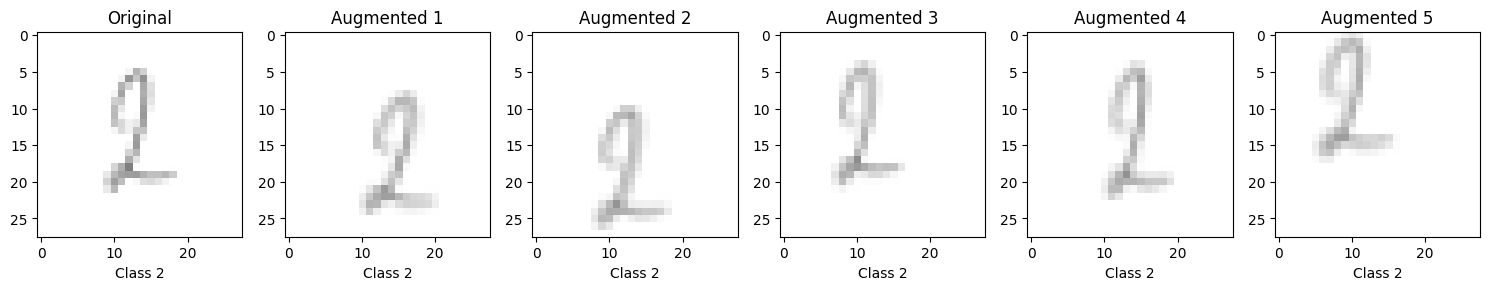

In [28]:

# Define class labels
class_labels = ["Class {}".format(i) for i in range(10)]  

# Choose a random index to visualize
index = np.random.randint(0, len(X_train))

# Original image
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(X_train[index])
plt.title('Original')
plt.xlabel(class_labels[np.argmax(y_train[index])]) 

# Augmented images (one from each class)
for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_X[index * 5 + i])
    plt.title('Augmented {}'.format(i + 1))
    plt.xlabel(class_labels[np.argmax(augmented_y[index * 5 + i])])  


plt.tight_layout()
plt.show()

# Convolutional Neural Network (CNN)

### Convolutional Neural Networks are a class of deep neural networks, most commonly applied to analyzing visual imagery

### Our Architecture employs the following layers:
* Conv2D
* MaxPooling2D
* Flatten
* Dense
* Dropout

## Explanation of each layer:
* `Conv2D` - Extracts features from the input image. With 32 filters and a kernal size of 3x3. The activation function used is `relu`

* `MaxPooling2D` - Reduces teh spatial dimension of the feature while retainign the most importatn information. pool size of 2x2 downsamples the input image

* `Flatten` - Transforms the 2D array to a 1D array. Enables the output to be processed by the dense layer

* `Dense` - Learns complex patterns in the data. The activation function used is `relu` (introduces non-linearity). Allows the model to learn high level features in the data. 

* `Dropout` - Regualrization tehcniuqe to prevent overfitting. Randomly sets 50% of the input units to 0 at each update during training to force NN to continue to learn.

* `Output` - The output layer with 10 nodes (one for each class). The activation function used is `softmax` to return the probability of each class.

### We used the `Adam` optimizer and `categorical_crossentropy` loss function




In [29]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(28, 28, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

def intialize_model_train(epoch, batch_size):
	print("******* training network *******")
# Compile the model with Adam optimizer
	adam_optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
	model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
	# go through the data 5 times with 128 batch sizes
	H = model.fit(augmented_X,augmented_y, validation_data=(X_test, y_test),
		epochs=epoch, batch_size=batch_size)

	# evaluate the network
	print("******* evaluating network *******")
	predictions = model.predict(X_test, batch_size=batch_size)
	print(classification_report(y_test.argmax(axis=1),
		predictions.argmax(axis=1)))

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,890 (1.61 MB)

 Trainable params: 422,890 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model 

### We trained the model for 10 epochs with a batch size of 32 

In [30]:
for i in range(1, 10):
    intialize_model_train(i, 32)

******* training network *******
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0899 - loss: 2.3120 - val_accuracy: 0.0750 - val_loss: 2.3087
******* evaluating network *******
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        21
           4       0.07      1.00      0.14        15
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        21

    accuracy                           0.07       200
   macro avg       0.01      0.10      0.01       200
weighted avg       0.01      0.07      0.01       200

******* training 

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1021 - loss: 2.3028 - val_accuracy: 0.0750 - val_loss: 2.3121
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1293 - loss: 2.2790 - val_accuracy: 0.2950 - val_loss: 1.7697
******* evaluating network *******
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
              precision    recall  f1-score   support

           0       0.25      0.90      0.39        20
           1       0.40      0.92      0.56        13
           2       0.00      0.00      0.00        27
           3       0.32      0.86      0.46        21
           4       0.26      0.60      0.36        15
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        25
           7       0.50      0.15      0.24        13
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        21

    accuracy                           0.29       200
   macro avg       0.17      0.

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2924 - loss: 1.9485 - val_accuracy: 0.4050 - val_loss: 1.5763
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3789 - loss: 1.6709 - val_accuracy: 0.5950 - val_loss: 1.0724
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4710 - loss: 1.4707 - val_accuracy: 0.7200 - val_loss: 0.8140
******* evaluating network *******
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.73      0.95      0.83        20
           1       0.86      0.92      0.89        13
           2       0.77      0.63      0.69        27
           3       0.91      0.48      0.62        21
           4       0.64      0.47      0.54        15
           5       0.64      0.82      0.72        22
           6       0.74      0.92      0.82        25
           7       0.80      0.92      0.86        13
           8       0.62      0.43      0.51        23
           9

# visualize the model predication 

#### Instead of a confusion matrix we decided to visualize the model predication on a sample of the test data

#### We wanted to let the users easily see the predication of the model on the test data. We have created a function that takes in the model and the test data and displays the predication of the model on the test data

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


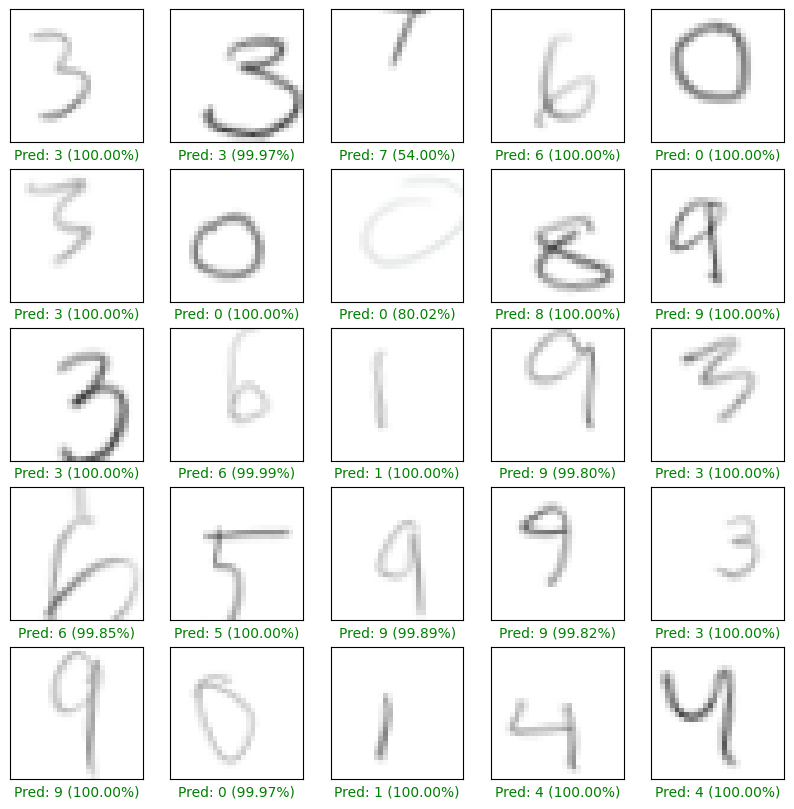

In [31]:
predictions = model.predict(augmented_X)
num_rows = 5
num_cols = 5
num_images = num_rows * num_cols

plt.figure(figsize=(10, 10))
random_indices = np.random.choice(len(augmented_X), size=num_images, replace=False)  # Randomly select indices
for i, index in enumerate(random_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_X[index], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions[index])
    true_label = np.argmax(augmented_y[index])
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Pred: {predicted_label} ({100*np.max(predictions[index]):.2f}%)', color=color)
    #plt.ylabel(f'True: {true_label}')
plt.show()

In [32]:
# Saving the model to a file to use for our pygames app
def Save_Model(model):
    #os.chdir("SavedModels")
    try:
        model.save("SavedModels/NN.keras")
    except Exception as e:
        print(f'Error saving model: {e}')

Save_Model(model)

# Conclusion 

#### Our MSU-NIST Final Project was a great experience for both of us to learn more about the background process of Machine Learning. In class, we have learned about the application of Machine Learning, but we have never had the opportunity to collect our own data and preprocess it. Deciding to collect our own handwritten digits on campus, although challenging and pushing us out of our comfort zone, allowed us to understand the entire process of collecting, ingesting, and processing data for a Machine Learning model. Additionally, because we opted for the self-collected data route, we were able to grasp the importance of data quality and how it can affect the performance of the model, which then led us to implement data augmentation to increase the size of our dataset. We believe that this project has given us a better understanding of the entire Machine Learning process and the challenges that come with it.

# code for presentation title  

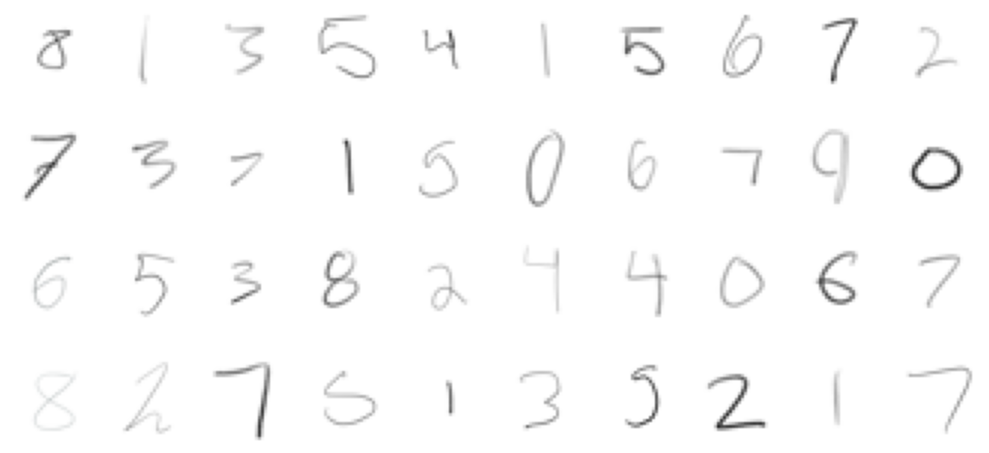

In [33]:
# print a random sample images
fig, axes = plt.subplots(4, 10, figsize=(10, 5))
axes = axes.ravel()

for i in range(40):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx])
    #axes[i].set_title(classes[np.argmax(y_train[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()